In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

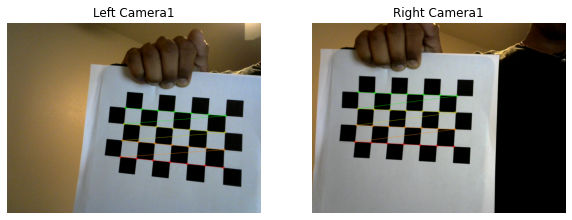

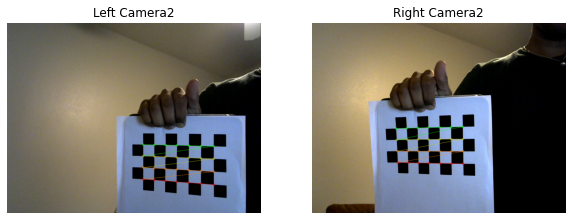

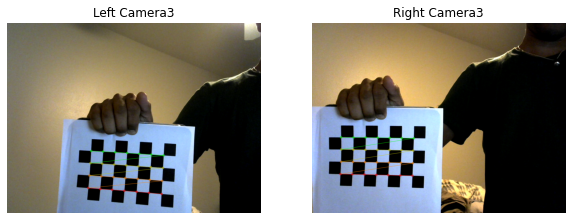

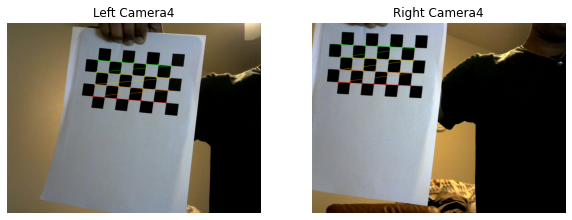

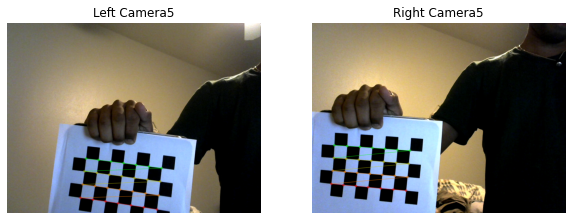

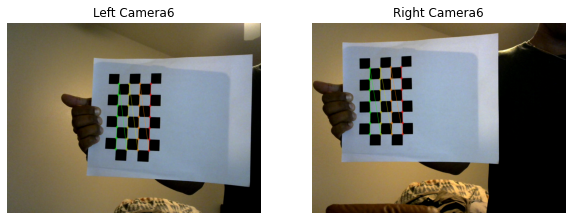

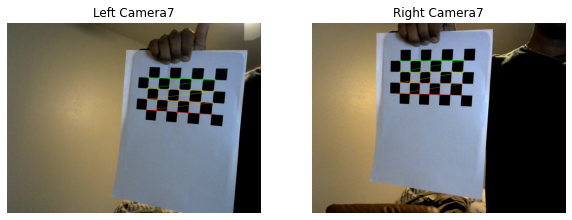

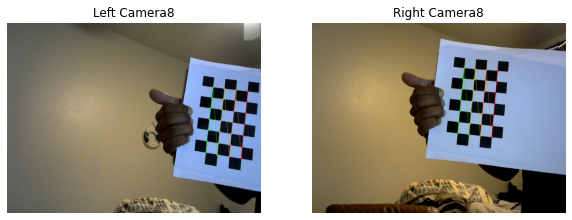

In [2]:
checkerboard_size = (7, 4)
frame_size = (960, 1280)

termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# object points
objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)

objp = objp * 19.5 # 19.5 mm between each square

objpoints = []  # real world points
imgpointsL = [] # image points from left camera
imgpointsR = [] # image points from right camera

# Path to images captured from the left and right cameras
left_images = glob.glob('/Users/siddharthiyer/Documents/GitHub/cv-final-visual-impairment-assistance/camera calibration/checkboard calibration/images/left cam/*.png')
right_images = glob.glob('/Users/siddharthiyer/Documents/GitHub/cv-final-visual-impairment-assistance/camera calibration/checkboard calibration/images/right cam/*.png')

for imgLeft, imgRight in zip(left_images, right_images):
    imgL = cv2.imread(imgLeft)
    imgR = cv2.imread(imgRight)

    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    retL, cornersL = cv2.findChessboardCorners(grayL, checkerboard_size, None)
    retR, cornersR = cv2.findChessboardCorners(grayR, checkerboard_size, None)

    if retL and retR:
        objpoints.append(objp)

        cornersL = cv2.cornerSubPix(grayL, cornersL, (11, 11), (-1, -1), termination_criteria)
        cornersR = cv2.cornerSubPix(grayR, cornersR, (11, 11), (-1, -1), termination_criteria)

        imgpointsL.append(cornersL)
        imgpointsR.append(cornersR)

        imgL = cv2.drawChessboardCorners(imgL, checkerboard_size, cornersL, retL)
        imgR = cv2.drawChessboardCorners(imgR, checkerboard_size, cornersR, retR)

        # Display images using matplotlib
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
        plt.title('Left Camera' + str(len(imgpointsL)))
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
        plt.title('Right Camera' + str(len(imgpointsR)))
        plt.axis('off')

        plt.show()

        cv2.waitKey(500)

In [5]:
# Calibrate the stereo camera system
ret, mtxL, distL, mtxR, distR, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpointsL, imgpointsR, None, None, None, None, frame_size,
    criteria=termination_criteria, flags=cv2.CALIB_FIX_INTRINSIC)

In [6]:
# Obtain rectification transform
rectify_scale = 0  # 0 for full crop, 1 for no crop
RL, RR, PL, PR, Q, roiL, roiR = cv2.stereoRectify(
    mtxL, distL, mtxR, distR, frame_size, R, T, alpha=rectify_scale)

# Compute the rectification map
mapL1, mapL2 = cv2.initUndistortRectifyMap(mtxL, distL, RL, PL, frame_size, cv2.CV_16SC2)
mapR1, mapR2 = cv2.initUndistortRectifyMap(mtxR, distR, RR, PR, frame_size, cv2.CV_16SC2)

In [7]:
# Using StereoSGBM for disparity calculation
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=64,  # max_disp has to be dividable by 16 f. E. HH 192, 256
    blockSize=5,
    P1=8 * 3 * 5 ** 2,  # 8*3*win_size**2
    P2=32 * 3 * 5 ** 2,  # 32*3*win_size**2
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Calculate disparity map
disparity = stereo.compute(cv2.remap(grayL, mapL1, mapL2, cv2.INTER_LINEAR),
                            cv2.remap(grayR, mapR1, mapR2, cv2.INTER_LINEAR))

In [8]:
f = mtxL[0, 0]  # focal length
B = np.linalg.norm(T) # estimated from translation
depth = f * B / disparity

<ipython-input-8-c71bbb39ef1c>:4: RuntimeWarning: divide by zero encountered in true_divide
  depth = f * B / disparity


In [10]:
disparity

array([[-16, -16, -16, ...,   0,   0,   0],
       [-16, -16, -16, ...,   0,   0,   0],
       [-16, -16, -16, ...,   0,   0,   0],
       ...,
       [-16, -16, -16, ...,   0,   0,   0],
       [-16, -16, -16, ...,   0,   0,   0],
       [-16, -16, -16, ...,   0,   0,   0]], dtype=int16)